# Chapter 8  階層モデル

説明変数だけでは説明がつかない、グループに由来する差異（グループ差）を扱う

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stan_jupyter as stan
import arviz as az
from PIL import Image
import numpy as np

from utils.glaph import pairplot

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

## 8.1 階層モデルの導入

#### データの確認

In [2]:
data = pd.read_csv("./data/data-salary-2.txt")
data.head()

,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


【カラムの説明】  
- X：年齢　ただし実際の年齢から23を引いている（新卒の年齢＝0にして、回帰の切片＝新卒の基本年収にするため）
- Y：年収
- KID：勤務している会社のID（1~4の整数）

【仮定】  
- 年収Y = 基本年収 + ノイズ（正規分布に従うその他の影響）
- 4社：年功序列型の賃金制度の会社であり、基本年収は年齢と正比例する
- グループ差：「新卒の基本年収」「年齢に伴う昇給額」は会社によって大きく異なる  
    →これがグループ差を考える動機となる。

### 8.1.1 解析の目的とデータの分布の確認

- 会社毎の年齢Xと基本年収Yの関係を知りたい
- 資料に載せたい情報は会社ごとの「新卒の基本年収」と「年齢に伴う昇給額」の事後分布

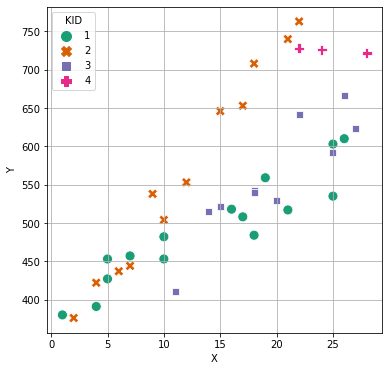

In [3]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x="X", y="Y", hue="KID", data=data, palette="Dark2", style="KID", size="KID", sizes=(100, 100))
plt.grid()
plt.show()

- 各社において、年齢に伴って年収は線形的に増加しそう
- KID=4に関してはデータ数が少なく、単純に直線をあてはめると傾きが負になる

### 8.1.2 グループ差を考えない場合

単純に一つの直線式 $a+bX$ で4社のデータに対して回帰を行う

■ モデル式 4-2（再掲） ■

$$
\begin{align}
  Y[n] &= y_{base}[n] + \epsilon[n]  \quad \qquad \qquad n=1,\cdots,N \\
  y_{base}[n] &= a + bX[n]  \qquad \qquad \qquad n=1,\cdots,N \\
  \epsilon[n] &\sim Normal(0, \sigma_Y)  \qquad \qquad n=1,\cdots,N \\
\end{align}
$$

書き換えると次のようになる。

■ モデル式 8-1 ■
$$
  Y[n] \sim Normal(a + bX[n], \sigma_Y)  \qquad \qquad n=1,\cdots,N \\
$$

In [4]:
stan_model = """
data {
    int N;
    real X[N];
    real Y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> s_Y;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a + b*X[n], s_Y);
    }
}
"""

stan_data = {
    "N": len(data),
    "X": data["X"].values,
    "Y": data["Y"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample()
fit.to_frame().describe()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_ha9np1g5/model_xkou5rjb.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ha9np1g5/model_xkou5rjb.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,s_Y
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000
mean,-184.114500,0.934550,0.304019,2.953750,10.145500,0.0,185.649228,375.275241,11.099690,68.570664
std,1.258832,0.092810,0.033929,0.804222,4.782316,0.0,1.783121,24.770869,1.433683,8.039096
min,-192.822861,0.256337,0.268766,1.000000,1.000000,0.0,182.600162,285.105632,5.059879,45.032519
25%,-184.739671,0.908734,0.278929,2.000000,7.000000,0.0,184.355552,358.531375,10.140530,62.866376
50%,-183.791337,0.971716,0.294817,3.000000,11.000000,0.0,185.318834,374.712475,11.119378,67.940324
75%,-183.185161,0.994297,0.319906,4.000000,15.000000,0.0,186.602433,391.671001,12.079749,73.567185
max,-182.547696,1.000000,0.357675,4.000000,31.000000,0.0,198.379555,484.609828,16.570842,107.606685


### 8.1.3 グループごとに切片と傾きを持つ場合

会社の数をKとして $a[1] \sim a[K]$ と $b[1] \sim b[K]$ を推定する

■ モデル式 8-2 ■
$$
  Y[n] \sim Normal(a[KID[n]] + b[KID[n]]*X[n], \sigma_Y)  \qquad \qquad n=1,\cdots,N \\
$$

以下ではa, bには特に事前分布を指定していないため、無情報事前分布が設定される

In [5]:
stan_model = """
data {
    int N;
    int K;
    real X[N];
    real Y[N];
    int<lower=1, upper=K> KID[N];
}

parameters {
    real a[K];
    real b[K];
    real<lower=0> s_Y;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
    }
}
"""

stan_data = {
    "N": len(data),
    "K": np.max(data["KID"]),
    "X": data["X"].values,
    "Y": data["Y"].values,
    "KID": data["KID"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample()
fit.to_frame().describe()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_gscl1852/model_hokfdpbz.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gscl1852/model_hokfdpbz.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gscl1852/model_hokfdpbz.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a.1,a.2,a.3,a.4,b.1,b.2,b.3,b.4,s_Y
count,4000.000000,4000.000000,4000.000000,4000.0000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-148.091031,0.932915,0.068870,5.5995,57.424000,0.0,152.558671,387.283034,328.899301,313.725706,751.745364,7.516002,19.832646,12.469642,-1.076936,27.320244
std,2.354705,0.094737,0.001759,0.6828,17.378139,0.0,3.101689,14.053244,16.797865,35.044775,159.015054,0.872082,1.240544,1.732734,6.418439,3.492702
min,-160.893623,0.239572,0.065878,2.0000,3.000000,0.0,145.017966,335.701307,263.008883,182.707454,216.252265,4.387483,15.246490,4.022607,-26.703152,17.341750
25%,-149.409151,0.911054,0.068645,5.0000,63.000000,0.0,150.382473,377.833542,317.870509,290.312931,645.288676,6.937385,18.997983,11.302729,-5.308362,24.944603
50%,-147.732159,0.971040,0.069594,6.0000,63.000000,0.0,152.208839,387.220221,328.626722,314.047576,752.582755,7.512012,19.849159,12.477312,-1.074339,27.031689
75%,-146.349907,0.992495,0.069819,6.0000,63.000000,0.0,154.386249,396.433154,340.270824,337.076611,855.534004,8.095336,20.667342,13.632421,3.276513,29.443657
max,-143.325965,1.000000,0.070412,7.0000,175.000000,0.0,166.727230,444.168106,382.515670,475.790795,1389.710292,11.469683,24.593821,19.172366,21.129719,42.865317


- 各会社の $a[k], b[k]$ について何の仮定もないので、a, bの会社による差がどれほどか推定できない。  
    →そのため、今回の4社以外の会社については切片と傾きがどの程度になりそうか答えられず、年収の予測ができない
- KID=4のケースで傾きが負になっているため、過学習が起きていると考えられる。
- データ量が少ないケースがよくあることなので何とかしたい

そこで、モデルを考え直し、グループ差に仮定を入れる

### 8.1.4 階層モデル

#### メカニズムの想像

- 各会社のa[k]を以下に分けて考える  
    - すべての会社で共通の全体平均
    - 会社差を表す項　→　$Normal(0, \sigma_a)$ から生成されると仮定

※b[k]についても同様に考える

■ モデル式 8-3 ■

$$
\begin{align}
  Y[n] &\sim Normal(a[KID[n]] + b[KID[n]]*X[n], \sigma_Y) \qquad n=1,\cdots,N \\
  a[k] &= a_{全体平均} + a_{会社差}[k]   \qquad \qquad \qquad \qquad \qquad \qquad \quad k=1,\cdots,K \\
  a_{会社差}[k] &= Normal(0, \sigma_a)  \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad k=1,\cdots,K \\
  b[k] &= b_{全体平均} + b_{会社差}[k]   \qquad \qquad \qquad \qquad \qquad \qquad \quad k=1,\cdots,K \\
  b_{会社差}[k] &= Normal(0, \sigma_b)  \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad k=1,\cdots,K \\
\end{align}
$$

- データから以下を推定する  
    - $\sigma_Y$
    - $a_{全体平均}$
    - $a_{会社差}[k]$
    - $\sigma_a$
    - $b_{全体平均}$
    - $b_{会社差}[k]$
    - $\sigma_b$
- $a_{全体平均}$, $b_{全体平均}$ の事前分布にも無情報事前分布を設定する

#### シミュレーション

In [6]:
def rep(vals: list[int], times: list[int]):
    target_vals = []
    for target, n in zip(vals, times):
        target_vals += [target] * n
    return target_vals


np.random.seed(123)
N = 40                 # データ数
K = 4                  # 会社数
N_k = [15, 12, 10, 3]  # 会社別のデータ数
a0 = 350               # 切片(新卒の平均年収)の全体平均
b0 = 12                # 傾き(年収の昇給幅)の全体平均
s_a = 60               # 切片(新卒の平均年収)の標準偏差
s_b = 4                # 傾き(年収の昇給幅)の標準偏差
s_Y = 25               # 年収の標準偏差

X = np.random.randint(0, 35, N)          # 年齢の乱数を生成
KID = rep(list(range(1, 5)), times=N_k)  # 会社ID

# a[k], b[k]を確率的に生成
a = a0 + np.random.normal(0, s_a, size=(K))
b = b0 + np.random.normal(0, s_b, size=(K))

# データフレーム化
df = pd.DataFrame()
df["X"] = X
df["KID"] = KID
df["a"] = rep(a, times=N_k)
df["b"] = rep(b, times=N_k)
df["Y_sim"] = df[["X", "a", "b"]].apply(lambda v: np.random.normal((v[1]+v[2]*v[0]), s_Y), axis=1)
df.head()

,X,KID,a,b,Y_sim
0,2,1,308.241129,10.621433,326.661362
1,28,1,308.241129,10.621433,564.123866
2,34,1,308.241129,10.621433,669.708323
3,17,1,308.241129,10.621433,497.239848
4,19,1,308.241129,10.621433,486.882787


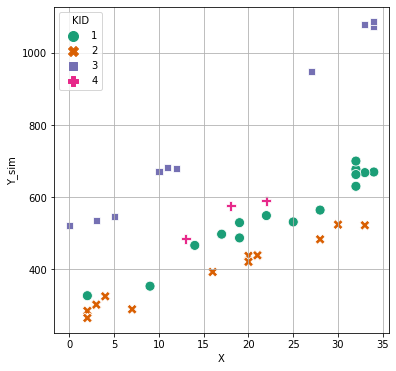

In [7]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x="X", y="Y_sim", hue="KID", data=df, palette="Dark2", style="KID", size="KID", sizes=(100, 100))
plt.grid()
plt.show()

- 各パラメータの値や乱数の種を変えて繰り返し実行することで、モデル式がどのようなデータを生成しやすいかを視覚的に確認できる

#### Stanで実装

In [8]:
stan_model = """
data {
    int N;
    int K;
    real X[N];
    real Y[N];
    int<lower=1, upper=K> KID[N];
}

parameters {
    real a0;
    real b0;
    real ak[K];
    real bk[K];
    real<lower=0> s_a;
    real<lower=0> s_b;
    real<lower=0> s_Y;
}

transformed parameters {
    real a[K];
    real b[K];
    for (k in 1:K) {
        a[k] = a0 + ak[k];
        b[k] = b0 + bk[k];
    }
}

model {
    for (k in 1:K) {
        ak[k] ~ normal(0, s_a);
        bk[k] ~ normal(0, s_b);
    }

    for (n in 1:N) {
        Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
    }
}
"""

stan_data = {
    "N": len(data),
    "K": np.max(data["KID"]),
    "X": data["X"].values,
    "Y": data["Y"].values,
    "KID": data["KID"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=1234)
fit = posterior.sample()
fit.to_frame().describe()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__hon353m/model_u7jysukg.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan__hon353m/model_u7jysukg.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan__hon353m/model_u7jysukg.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a0,b0,ak.1,ak.2,ak.3,ak.4,bk.1,bk.2,bk.3,bk.4,s_a,s_b,s_Y,a.1,a.2,a.3,a.4,b.1,b.2,b.3,b.4
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-173.074279,0.917740,0.029126,6.302000,123.490750,0.000250,179.623409,381.446829,12.442669,1.731781,-45.530111,-55.730971,93.319814,-4.685831,6.890658,-0.548790,-2.411446,151.673827,11.862179,28.712663,383.178610,335.916718,325.715857,474.766643,7.756838,19.333327,11.893879,10.031223
std,3.401397,0.107951,0.004285,0.916246,82.870141,0.015811,4.284558,139.439173,8.208686,139.453828,140.481053,142.048842,164.346780,8.210548,8.237457,8.290719,9.316004,228.844279,14.082072,4.063582,15.164386,17.842800,33.553281,134.698511,0.931528,1.321883,1.650557,5.417720
min,-187.565681,0.044213,0.024237,2.000000,7.000000,0.000000,167.967679,-1569.427546,-50.360512,-1116.081447,-1183.731116,-1227.483627,-959.528795,-69.375801,-59.415062,-64.857953,-71.746890,2.113952,2.110413,18.099233,320.598251,274.670852,194.564195,170.445845,4.473918,14.379180,5.490686,-13.424010
25%,-175.136196,0.892453,0.025571,6.000000,63.000000,0.000000,176.575505,340.875645,9.231874,-24.576063,-76.586728,-90.651236,6.450047,-7.376545,3.976442,-3.620641,-5.859422,43.286276,5.587206,25.784761,373.280024,323.628396,303.982789,373.482703,7.134189,18.452012,10.756888,6.998772
50%,-172.729682,0.958577,0.028580,6.000000,127.000000,0.000000,179.346276,367.971972,12.422799,11.691600,-29.985125,-37.695180,55.250865,-4.551922,6.854518,-0.375831,-1.463742,89.631163,8.046046,28.250494,383.533922,335.690920,326.600678,440.219451,7.727399,19.337165,11.872032,11.363430
75%,-170.653008,0.987924,0.032136,7.000000,127.000000,0.000000,182.264771,410.081605,15.177934,42.248273,-1.119789,-4.381764,145.398272,-1.488059,10.063757,2.657637,2.057421,177.404529,12.748319,31.106999,393.311830,347.825496,349.354435,548.842674,8.362557,20.245037,12.970641,14.118238
max,-163.170478,1.000000,0.035108,10.000000,1023.000000,1.000000,199.464936,1514.768394,77.720095,1963.832399,1908.033890,1865.392295,2201.512233,55.911610,71.954977,62.669298,58.140045,5066.869396,240.788499,49.055810,439.701800,407.630746,438.170526,1080.198324,12.129172,23.959596,18.638896,23.101036


- 4社分のデータしかないため各パラメータのベイズ信頼区間は広く推定されている
- $b_{全体平均}$にマイナスの値が含まれる、$\sigma_a$ に600万えんという大きな値が95％区間に含まれるなど、常識から考えにくい点がある。

→対処法として弱情報事前分布を活用する方法があるが10章で扱う

### 3.1.5 モデルの比較

※ グラフィカルモデルの図はテキストを参照

推定されたa[k]について、モデル式8-2と8-3の結果を比べる。

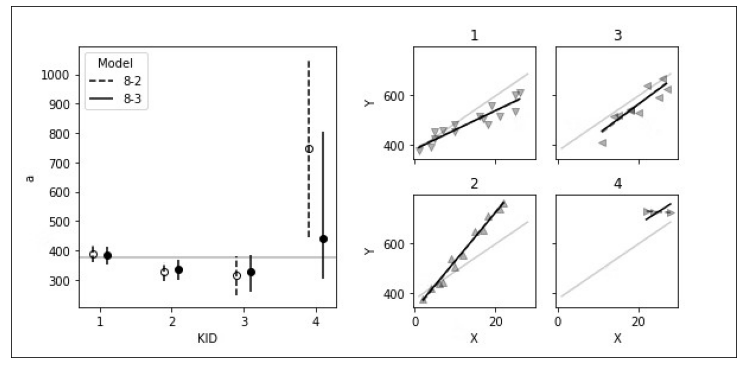

In [9]:
def img_show(img_path: str, figsize: tuple[int, int] = (7, 5)):
    img = Image.open(img_path)
    img_array = np.asarray(img)
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_array)
    plt.show()

img_show("./data/8-4.jpg", figsize=(13, 10))

- 8-3の方が各a[k]がデータ全体から求めたa(図中の灰色の実践)に近くなるように推定されている
- KID=4のように、a[k]の値が灰色の実線から離れるほど推定値の差が大きくなる  
→　これは「各a[k]は特定の分布から生成される」という仮定が入っているため  
→　階層モデルの場合に推定値が「縮む」現象を「shrinkage(主リンケージ)」と呼ぶ  
→　これにより過学習を避けている  


### 8.1.6 階層モデルの等価な表現

■ モデル式 8-4 ■

$$
\begin{align*}
  Y[n] &\sim Normal(a[KID[n]] + b[KID[n]]*X[n], \sigma_Y) \qquad n=1,\cdots,N \\
  a[k] &\sim Normal(a_{全体平均}, \sigma_a)   \qquad \qquad \qquad \qquad \qquad \qquad  k=1,\cdots,K \\
  b[k] &\sim Normal(b_{全体平均}, \sigma_b)   \qquad \qquad \qquad \qquad \qquad \qquad  k=1,\cdots,K \\
\end{align*}
$$

- 各社のa[k] は $a_{全体平均}$ を平均とした正規分布から生成された　という意味になっている
- これにより計算速度や収束しやすさが大きく異なる

※bについても同様  
※場合によっては計算速度が遅くなったり、収束しにくくなることもあるため注意

In [10]:
stan_model = """
data {
    int N;
    int K;
    real X[N];
    real Y[N];
    int<lower=1, upper=K> KID[N];
}

parameters {
    real a0;
    real b0;
    real a[K];
    real b[K];
    real<lower=0> s_a;
    real<lower=0> s_b;
    real<lower=0> s_Y;
}

model {
    for (k in 1:K) {
        a[k] ~ normal(a0, s_a);
        b[k] ~ normal(b0, s_b);
    }

    for (n in 1:N) {
        Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
    }
}
"""

stan_data = {
    "N": len(data),
    "K": np.max(data["KID"]),
    "X": data["X"].values,
    "Y": data["Y"].values,
    "KID": data["KID"].values,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=1234)
fit = posterior.sample()
fit.to_frame().describe()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_gcjwzj95/model_e5oslnkf.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gcjwzj95/model_e5oslnkf.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gcjwzj95/model_e5oslnkf.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a0,b0,a.1,a.2,a.3,a.4,b.1,b.2,b.3,b.4,s_a,s_b,s_Y
count,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-173.060327,9.196240e-01,0.077041,5.357750,54.696500,0.009750,179.575379,382.039600,12.269338,383.241014,335.359487,324.197228,480.934675,7.760126,19.358531,11.961403,9.804851,157.867537,12.319459,28.466858
std,3.372351,1.411689e-01,0.007678,0.721037,23.197078,0.098272,4.236277,117.876227,8.229167,14.730738,18.076842,33.607290,132.554104,0.915544,1.328223,1.667325,5.341109,195.663688,16.196430,3.893496
min,-191.217169,7.580418e-09,0.069818,1.000000,3.000000,0.000000,168.708333,-696.675422,-66.645989,327.399805,270.875417,195.226069,190.729949,4.399460,13.304694,5.717541,-18.141064,7.040314,1.734063,18.708016
25%,-175.055279,9.117890e-01,0.072888,5.000000,31.000000,0.000000,176.519179,340.069409,9.417377,373.397420,323.344039,301.824252,378.482476,7.152457,18.458010,10.773863,6.725518,46.925354,5.668565,25.605976
50%,-172.679737,9.674724e-01,0.074188,5.000000,63.000000,0.000000,179.225846,368.093207,12.374978,383.107050,335.582345,324.957051,446.154889,7.762154,19.409068,11.919621,11.139221,96.614138,8.184477,28.085989
75%,-170.632615,9.912839e-01,0.078342,6.000000,63.000000,0.000000,182.220854,412.633301,15.221826,392.917879,347.397423,348.054348,557.246525,8.374435,20.230665,13.081409,13.890022,194.996007,12.859251,30.948090
max,-165.234506,1.000000e+00,0.089969,7.000000,223.000000,1.000000,198.464622,1306.528496,82.130418,438.636184,413.182580,441.529145,1200.097354,11.041981,24.431423,17.946850,22.491563,3256.104730,280.431026,46.059634


## 練習問題

In [11]:
df_7a = pd.read_csv("./data/data7a.csv")
df_7a.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


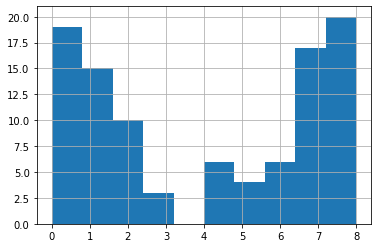

In [16]:
n = len(df_7a["y"])
plt.hist(df_7a["y"], bins=10)
plt.grid()
plt.show()

$$
  y \sim Pi
$$

$Y \sim $